In [2]:
# Author: Decebal Constantin Mocanu et al.;
# Proof of concept implementation of Sparse Evolutionary Training (SET) of Multi Layer Perceptron (MLP) on CIFAR10 using Keras and a mask over weights.
# This implementation can be used to test SET in varying conditions, using the Keras framework versatility, e.g. various optimizers, activation layers, tensorflow
# Also it can be easily adapted for Convolutional Neural Networks or other models which have dense layers
# However, due the fact that the weights are stored in the standard Keras format (dense matrices), this implementation can not scale properly.
# If you would like to build and SET-MLP with over 100000 neurons, please use the pure Python implementation from the folder "SET-MLP-Sparse-Python-Data-Structures"

# This is a pre-alpha free software and was tested with Python 3.5.2, Keras 2.1.3, Keras_Contrib 0.0.2, Tensorflow 1.5.0, Numpy 1.14;
# The code is distributed in the hope that it may be useful, but WITHOUT ANY WARRANTIES; The use of this software is entirely at the user's own risk;
# For an easy understanding of the code functionality please read the following articles.

# If you use parts of this code please cite the following articles:
#@article{Mocanu2018SET,
#  author =        {Mocanu, Decebal Constantin and Mocanu, Elena and Stone, Peter and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio},
#  journal =       {Nature Communications},
#  title =         {Scalable Training of Artificial Neural Networks with Adaptive Sparse Connectivity inspired by Network Science},
#  year =          {2018},
#  doi =           {10.1038/s41467-018-04316-3}
#}

#@Article{Mocanu2016XBM,
#author="Mocanu, Decebal Constantin and Mocanu, Elena and Nguyen, Phuong H. and Gibescu, Madeleine and Liotta, Antonio",
#title="A topological insight into restricted Boltzmann machines",
#journal="Machine Learning",
#year="2016",
#volume="104",
#number="2",
#pages="243--270",
#doi="10.1007/s10994-016-5570-z",
#url="https://doi.org/10.1007/s10994-016-5570-z"
#}

#@phdthesis{Mocanu2017PhDthesis,
#title = "Network computations in artificial intelligence",
#author = "D.C. Mocanu",
#year = "2017",
#isbn = "978-90-386-4305-2",
#publisher = "Eindhoven University of Technology",
#}\\\

# Alterations made by Andrew Heath


# Install requirements
!pip3 install tensorflow
!pip3 install --upgrade tensorflow
!pip3 install graphviz
!pip3 install keras-visualizer

# Set up

In [3]:

from __future__ import division
from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras import models, layers  
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import utils as k_utils

from keras_visualizer import visualizer 



#Please note that in newer versions of keras_contrib you may encounter some import errors. You can find a fix for it on the Internet, or as an alternative you can try other activations functions.
# import tf.keras.activations.relu as SReLU
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline  

class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class MaskWeights(Constraint):

    def __init__(self, mask):
        self.mask = mask
        self.mask = K.cast(self.mask, K.floatx())

    def __call__(self, w):
        w = w.assign(w * self.mask)
        return w

    def get_config(self):
        return {'mask': self.mask}


def find_first_pos(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


def find_last_pos(array, value):
    idx = (np.abs(array - value))[::-1].argmin()
    return array.shape[0] - idx


def createWeightsMask(epsilon,noRows, noCols):
    # generate an Erdos Renyi sparse weights mask
    mask_weights = np.random.rand(noRows, noCols)
    prob = 1 - (epsilon * (noRows + noCols)) / (noRows * noCols)  # normal tp have 8x connections
    mask_weights[mask_weights < prob] = 0
    mask_weights[mask_weights >= prob] = 1
    noParameters = np.sum(mask_weights)
    print ("Create Sparse Matrix: No parameters, NoRows, NoCols ",noParameters,noRows,noCols)
    return [noParameters,mask_weights]

# Init & Parameters

In [4]:
class SET_MLP_CIFAR10():
    def __init__(self):
        # set model parameters
        self.epsilon = 20 # control the sparsity level as discussed in the paper
        self.zeta = 0.3 # the fraction of the weights removed
        self.batch_size = 100 # batch size
        self.maxepoches = 10 # number of epochs
        self.learning_rate = 0.01 # SGD learning rate
        self.num_classes = 10 # number of classes
        self.momentum=0.9 # SGD momentum

        # generate an Erdos Renyi sparse weights mask for each layer
        [self.noPar1, self.wm1] = createWeightsMask(self.epsilon,32 * 32 *3, 4000)
        [self.noPar2, self.wm2] = createWeightsMask(self.epsilon,4000, 1000)
        [self.noPar3, self.wm3] = createWeightsMask(self.epsilon,1000, 4000)

        # initialize layers weights
        self.w1 = None
        self.w2 = None
        self.w3 = None
        self.w4 = None

        # initialize weights for SReLu activation function
        self.wSRelu1 = None
        self.wSRelu2 = None
        self.wSRelu3 = None

        # create a SET-MLP model
        self.create_model()

        # train the SET-MLP model
        self.train()

# Create model

In [5]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def create_model(self):

        # create a SET-MLP model for CIFAR10 with 3 hidden layers
        self.model = Sequential()
        self.model.add(Flatten(input_shape=(32, 32, 3)))
        self.model.add(Dense(4000, name="sparse_1",kernel_constraint=MaskWeights(self.wm1),weights=self.w1))
    #         self.model.add(SReLU(name="srelu1",weights=self.wSRelu1))
        self.model.add(layers.Activation(activations.relu,name="srelu1",weights=self.wSRelu1))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1000, name="sparse_2",kernel_constraint=MaskWeights(self.wm2),weights=self.w2))
    #         self.model.add(SReLU(name="srelu2",weights=self.wSRelu2))
        self.model.add(layers.Activation(activations.relu,name="srelu2",weights=self.wSRelu2))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(4000, name="sparse_3",kernel_constraint=MaskWeights(self.wm3),weights=self.w3))
    #         self.model.add(SReLU(name="srelu3",weights=self.wSRelu3))
        self.model.add(layers.Activation(activations.relu,name="srelu3",weights=self.wSRelu3))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(self.num_classes, name="dense_4",weights=self.w4)) #please note that there is no need for a sparse output layer as the number of classes is much smaller than the number of input hidden neurons
        self.model.add(Activation('softmax'))

# Rewrite mask

In [6]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def rewireMask(self,weights, noWeights):
        # rewire weight matrix

        # remove zeta largest negative and smallest positive weights
        values = np.sort(weights.ravel())
        firstZeroPos = find_first_pos(values, 0)
        lastZeroPos = find_last_pos(values, 0)
        largestNegative = values[int((1-self.zeta) * firstZeroPos)]
        smallestPositive = values[int(min(values.shape[0] - 1, lastZeroPos +self.zeta * (values.shape[0] - lastZeroPos)))]
        rewiredWeights = weights.copy();
        rewiredWeights[rewiredWeights > smallestPositive] = 1;
        rewiredWeights[rewiredWeights < largestNegative] = 1;
        rewiredWeights[rewiredWeights != 1] = 0;
        weightMaskCore = rewiredWeights.copy()

        # add zeta random weights
        nrAdd = 0
        noRewires = noWeights - np.sum(rewiredWeights)
        while (nrAdd < noRewires):
            i = np.random.randint(0, rewiredWeights.shape[0])
            j = np.random.randint(0, rewiredWeights.shape[1])
            if (rewiredWeights[i, j] == 0):
                rewiredWeights[i, j] = 1
                nrAdd += 1

        return [rewiredWeights, weightMaskCore]


# Find Centrailities 

In [7]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def visualise(self):
        visualizer(self.model, view=True)


# Weight evolution

In [22]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def weightsEvolution(self):
        # this represents the core of the SET procedure. It removes the weights closest to zero in each layer and add new random weights
        self.w1 = self.model.get_layer("sparse_1").get_weights()
        self.w2 = self.model.get_layer("sparse_2").get_weights()
        self.w3 = self.model.get_layer("sparse_3").get_weights()
        self.w4 = self.model.get_layer("dense_4").get_weights()
       
        print(self.w1)
#         print(len(self.w1) if self.w1 != None else -1 )
#         print(len(self.wSRelu1) if self.wSRelu1 !=	 None else -1)
#         print(len(self.w2) if self.w2 != None else -1)
#         print(len(self.wSRelu2) if self.wSRelu2 != None else -1)
#         print(len(self.w3) if self.w3 != None else -1)
#         print(len(self.wSRelu3) if self.wSRelu3 != None else -1)
#         print(len(self.w4) if self.w4 != None else -1)
    
        self.wSRelu1 = self.model.get_layer("srelu1").get_weights()
        self.wSRelu2 = self.model.get_layer("srelu2").get_weights()
        self.wSRelu3 = self.model.get_layer("srelu3").get_weights()

        [self.wm1, self.wm1Core] = self.rewireMask(self.w1[0], self.noPar1)
        [self.wm2, self.wm2Core] = self.rewireMask(self.w2[0], self.noPar2)
        [self.wm3, self.wm3Core] = self.rewireMask(self.w3[0], self.noPar3)

        self.w1[0] = self.w1[0] * self.wm1Core
        self.w2[0] = self.w2[0] * self.wm2Core
        self.w3[0] = self.w3[0] * self.wm3Core
        
        


# Read data

In [14]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def read_data(self):

        #read CIFAR10 data
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        y_train = to_categorical(y_train, self.num_classes)
        y_test = to_categorical(y_test, self.num_classes)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')

        #normalize data
        xTrainMean = np.mean(x_train, axis=0)
        xTtrainStd = np.std(x_train, axis=0)
        x_train = (x_train - xTrainMean) / xTtrainStd
        x_test = (x_test - xTrainMean) / xTtrainStd

        return [x_train, x_test, y_train, y_test]

# Training


In [15]:
class SET_MLP_CIFAR10(SET_MLP_CIFAR10):
    def train(self):

            # read CIFAR10 data
            [x_train,x_test,y_train,y_test]=self.read_data()

            #data augmentation
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images
            datagen.fit(x_train)

            self.model.summary()

            # training process in a for loop
            self.accuracies_per_epoch=[]
#             for epoch in range(0,self.maxepoches):
            for epoch in range(0,1):

                sgd = optimizers.SGD(lr=self.learning_rate, momentum=self.momentum)
                self.model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

                history = self.model.fit(datagen.flow(x_train, y_train,
                                                 batch_size=self.batch_size),
#                                 steps_per_epoch=x_train.shape[0]//self.batch_size,
                                 steps_per_epoch=1,
                                    epochs=epoch,
                                    validation_data=(x_test, y_test),
                                     initial_epoch=epoch-1)
      
                self.accuracies_per_epoch.append(history.history['val_accuracy'][0])

                #ugly hack to avoid tensorflow memory increase for multiple fit_generator calls. Theano shall work more nicely this but it is outdated in general
                self.weightsEvolution()
                K.clear_session()
                self.create_model()
 

            return self.accuracies_per_epoch
           


# Run 

Create Sparse Matrix: No parameters, NoRows, NoCols  141436.0 3072 4000
Create Sparse Matrix: No parameters, NoRows, NoCols  99980.0 4000 1000
Create Sparse Matrix: No parameters, NoRows, NoCols  100449.0 1000 4000
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
sparse_1 (Dense)             (None, 4000)              12292000  
_________________________________________________________________
srelu1 (Activation)          (None, 4000)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4000)              0         
_________________________________________________________________
sparse_2 (Dense)             (None, 1000)              4001000   
_____________________________________

TypeError: float() argument must be a string or a number, not 'SET_MLP_CIFAR10'

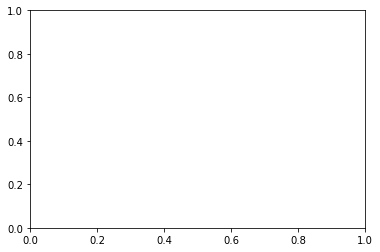

In [23]:

# create and run a SET-MLP model on CIFAR10
results_accu=SET_MLP_CIFAR10()
plt.plot(results_accu)
plt.title('model accuracy using SET')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# save accuracies over for all training epochs
# in "results" folder you can find the output of running this file

